In [1]:
import os
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, RandomFlip# type: ignore
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import VGG19

from sklearn.metrics import confusion_matrix
main_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\Tuberculosis_(TB)_Chest_X-ray_Database\\TB_Chest_Radiography_Database"
directories = os.listdir(main_path)
images = []
labels = []
for direct in directories:
    #print(direct)
    path1 = os.path.join(main_path, direct)
    files = os.listdir(path1)
    if direct == "Normal":
        code = 0
    elif direct == "Tuberculosis":
        code = 1
    
    counter = 0
    for file in files:
        if counter <2600:
            img = cv2.imread(os.path.join(path1,file))
            img = cv2.resize(img, (200,200))
            labels.append(code)
            images.append(img)
            counter += 1


In [2]:
images = np.asarray(images)
labels = np.asarray(labels)
display("Shape of Images" , images.shape, "Label Shape", labels.shape)

'Shape of Images'

(3300, 200, 200, 3)

'Label Shape'

(3300,)

In [3]:
data = images/255.0

In [4]:
X_train,X_test_combined, y_train, y_test_combined = train_test_split(data, labels, test_size=0.4, shuffle=True)


In [5]:
X_val, X_test, y_val, y_test = train_test_split(X_test_combined, y_test_combined, test_size=0.5, shuffle=True)

In [7]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(200, 200, 3))

In [ ]:


x = base_model.output
print(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation= 'softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

<KerasTensor shape=(None, 6, 6, 512), dtype=float32, sparse=False, name=keras_tensor_21>


In [9]:
for layer in model.layers[:-3]:
    layer.trainable = False
    

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [11]:
model.fit(X_train, y_train, epochs=8, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 391s 6s/step - binary_accuracy: 0.7961 - loss: 1.1826 - val_binary_accuracy: 0.9864 - val_loss: 0.0630
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 450s 7s/step - binary_accuracy: 0.9847 - loss: 0.0608 - val_binary_accuracy: 0.9909 - val_loss: 0.0353
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 403s 7s/step - binary_accuracy: 0.9959 - loss: 0.0244 - val_binary_accuracy: 0.9894 - val_loss: 0.0319
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 397s 6s/step - binary_accuracy: 0.9958 - loss: 0.0216 - val_binary_accuracy: 0.9955 - val_loss: 0.0202
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 392s 6s/step - binary_accuracy: 0.9963 - loss: 0.0189 - val_binary_accuracy: 0.9939 - val_loss: 0.0200
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 408s 7s/step - binary_accuracy: 0.9998 - loss: 0.0093 - val_binary_accuracy: 0.9955 - val_loss: 0.0163
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 405s 7s/step - binary_accuracy: 0.9985 - loss: 0.0094 - val_binary_accuracy: 0.9970 - val_loss: 0.0141
Epoch 8/10
62

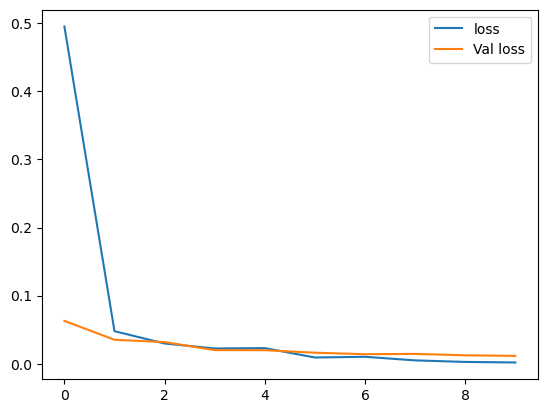

In [12]:
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

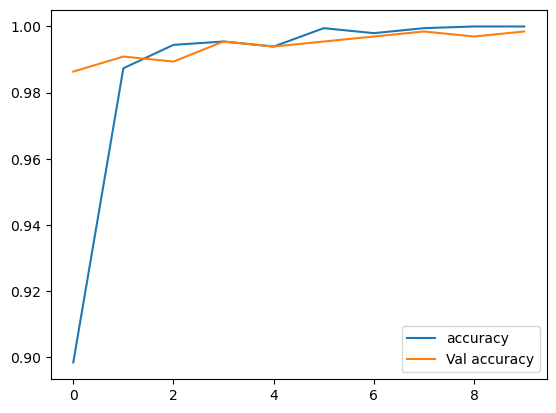

In [13]:
plt.plot(model.history.history['binary_accuracy'], label='accuracy')
plt.plot(model.history.history['val_binary_accuracy'], label='Val accuracy')
plt.legend()
plt.show()

In [14]:
result = model.evaluate(X_test, y_test, batch_size=32)


print(f'The accuracy is {result[1]}')
print(f'The loss is {result[0]}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - binary_accuracy: 0.9906 - loss: 0.0433
The accuracy is 0.989393949508667
The loss is 0.03370758891105652


In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


y_pred = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step


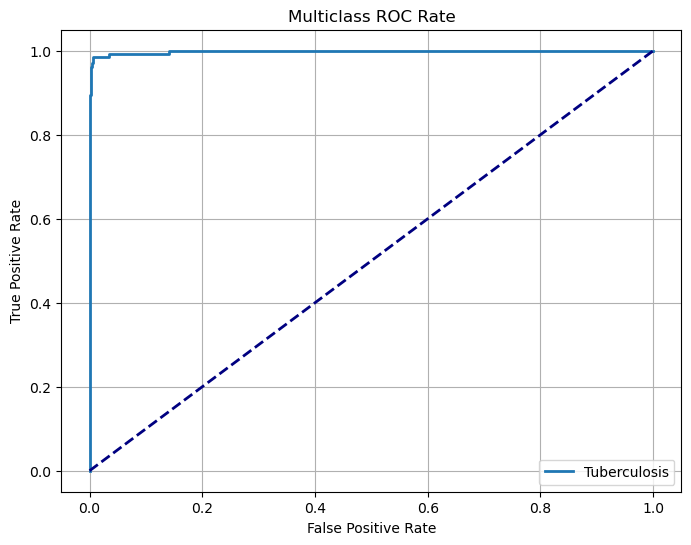

AUROC for class Tuberculosis : 0.998


In [16]:
y_true = y_test
n_classes = 2
fpr = {}
tpr = {}
# roc_auc = {}
classes_names = {0:"Normal", 1:"Tuberculosis"}
classes_names_list = ["Tuberculosis"]


fpr, tpr,  _ =  roc_curve(y_true, y_pred)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,6))

plt.plot(
    fpr, tpr, 
    lw=2,
    label=f"Class {1} (area = {roc_auc:.3f})"
)

plt.plot([0,1], [0,1], color="navy", lw=2, linestyle= "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Rate")
plt.legend(classes_names_list, loc="lower right")
plt.grid()
plt.show()


print(f"AUROC for class {classes_names[1]} : {roc_auc:.3f}")


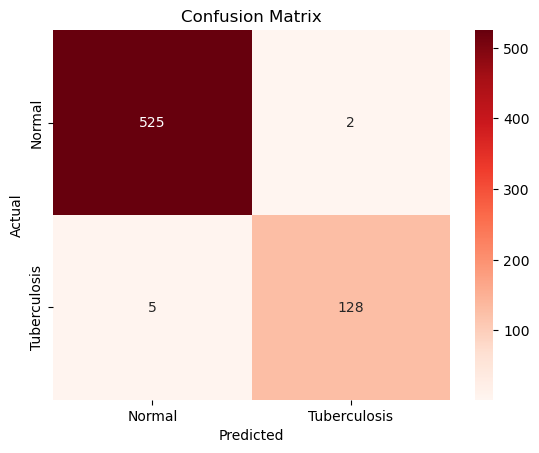

In [17]:
cm = confusion_matrix(y_true=y_true, y_pred=np.round(y_pred))

sns.heatmap(cm, cmap="Reds", 
            annot=True, 
            fmt='g',
            xticklabels=["Normal","Tuberculosis"],
            yticklabels=["Normal","Tuberculosis"],
            )

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
print(f"Sensitivity to correctly classifiy a CXR with TB {cm[1][1]/(cm[1][1]+cm[1][0]):.3f}")
print(f"Specificity to correctly classifiy a CXR with TB {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")

Sensitivity to correctly classifiy a CXR with TB 0.962
Specificity to correctly classifiy a CXR with TB 0.985


In [19]:

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           25

 Total params: 34,181,701 (130.39 MB)

 Trainable params: 4,719,105 (18.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 9,438,212 (36.00 MB)

In [20]:
model.save("cxr_normal_tb_vgg16_model.keras")

In [21]:
from tensorflow.keras.models import load_model
model = load_model("cxr_normal_tb_vgg16_model.keras")

In [23]:

img_size  = (200, 200)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block5_conv3"

img_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\Tuberculosis_(TB)_Chest_X-ray_Database\\TB_Chest_Radiography_Database\\Tuberculosis\\Tuberculosis-57.png"

img = Image.open(img_path)
img.show()

In [24]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output@pooled_grads[..., tf.newaxis]
    heatmap = tf.sequeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)/tf.math.reduce_max(heatmap)

    return heatmap.numpy()




In [25]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

model.layers[-1].activation = None

preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Received array with shape: (1, 1)

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255*heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]

    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap*alpha+img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)


save_and_display_gradcam(img_path, heatmap)


Next Steps
1. Train on more data
2. Augument the Data
3. Create a model that identifies if an image is a CXR before predicting if TB is present or not 
4. Send an Alert is TB is likely
5. Segment Abnormal area